# Downloading and Unzipping the Data

In [1]:
!gdown "https://drive.google.com/uc?id=1_R-ua-F4PsirGc6TTL_DM8i_o9m4PE8v"
!unzip -q "./dataset (2).zip"

Downloading...
From (original): https://drive.google.com/uc?id=1_R-ua-F4PsirGc6TTL_DM8i_o9m4PE8v
From (redirected): https://drive.google.com/uc?id=1_R-ua-F4PsirGc6TTL_DM8i_o9m4PE8v&confirm=t&uuid=f9c9c911-2d85-4877-8a5d-6756a909f85e
To: /kaggle/working/dataset (2).zip
100%|███████████████████████████████████████| 1.13G/1.13G [00:06<00:00, 161MB/s]


# Import the essential Libraries

In [2]:

import os  # Operating system interaction
import numpy as np  # Numerical computations
from tqdm import tqdm
import matplotlib.pyplot as plt  # Plotting
import torch  # Deep learning framework
import torchvision  # Computer vision utilities
import torch.nn as nn  # Neural network building blocks
import torch.optim as optim  # Optimization algorithms
from torch.autograd import Variable  # Automatic differentiation
from torchvision import datasets, transforms, models  # Pre-trained models
from tqdm.notebook import tqdm  # Progress bars
from sklearn.metrics import roc_auc_score, roc_curve, auc  # ROC curve metrics
from sklearn.preprocessing import label_binarize  # Label binarization

# Set matplotlib backend for inline plotting
%matplotlib inline

# Plotting Images from different classes

Class : no substructure 


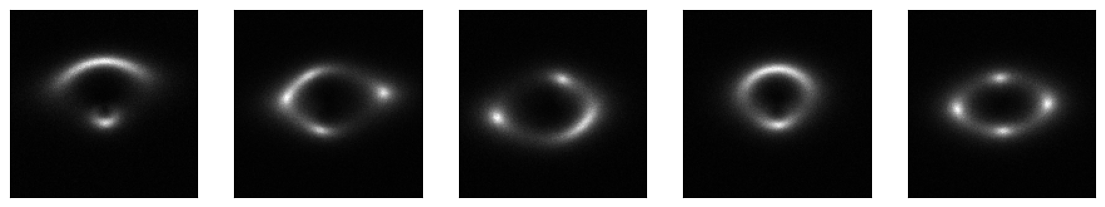

Class : Spherical substructure 


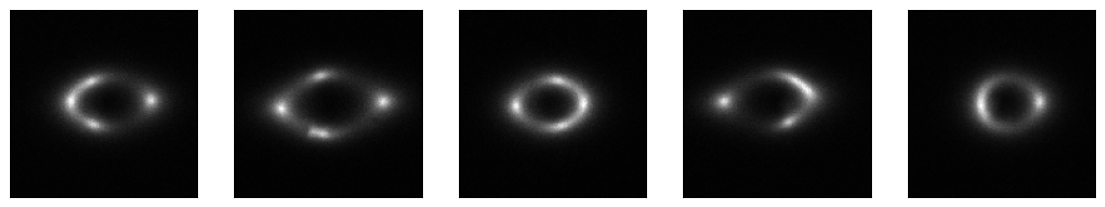

Class : Vortex substructure 


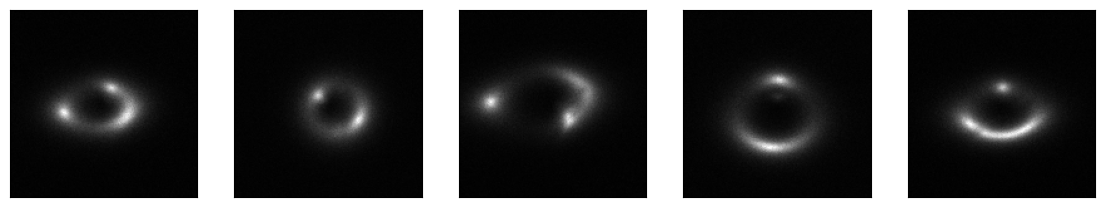

In [3]:
# Defining the input paths for different classes
train_path1 = './dataset/train/no'  # Path for samples with no substructure
train_files1 = [os.path.join(train_path1, f) for f in os.listdir(train_path1) if f.endswith(".npy")]

train_path2 = './dataset/train/sphere'  # Path for samples with spherical substructure
train_files2 = [os.path.join(train_path2, f) for f in os.listdir(train_path2) if f.endswith(".npy")]

train_path3 = './dataset/train/vort'  # Path for samples with vortex substructure
train_files3 = [os.path.join(train_path3, f) for f in os.listdir(train_path3) if f.endswith(".npy")]

# Number of samples to display per class
n = 5

# Plotting the samples with no substructure
print('Class : no substructure ')
plt.rcParams['figure.figsize'] = [14, 14]  # Set the size of the plot
for i, image in enumerate(train_files1[:n], 1):
    ax = plt.subplot(1, n, i)  # Creating subplot
    plt.imshow(np.load(image).reshape(150, 150), cmap='gray')  # Loading and displaying the image
    ax.get_xaxis().set_visible(False)  # Hide x-axis
    ax.get_yaxis().set_visible(False)  # Hide y-axis
plt.show()

# Plotting the samples with spherical substructure
print("Class : Spherical substructure ")
plt.rcParams['figure.figsize'] = [14, 14]
for i, image in enumerate(train_files2[:n], 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(np.load(image).reshape(150, 150), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Plotting the samples with vortex substructure
print("Class : Vortex substructure ")
plt.rcParams['figure.figsize'] = [14, 14]
for i, image in enumerate(train_files3[:n], 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(np.load(image).reshape(150, 150), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Creating Pytorch format Dataset and Dataloder

In [4]:
batch_size = 32  # Batch size for training

def load_img(path):

    tensor = torch.from_numpy(np.load(path))
    tensor = tensor.type('torch.FloatTensor')
    return tensor

def transform_img(img):
      transformer = transforms.Compose([
          transforms.Resize((150, 150)),
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(),
          transforms.RandomRotation(20),
          transforms.Normalize(mean=[0.5], std=[0.5])
      ])
      img = transformer(img)
      return img

# creating training dataset in pytorch format
train_path = "./dataset/train"
train_data = torchvision.datasets.DatasetFolder(root=train_path, loader=load_img,transform= transform_img, extensions="npy")
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# creating validation dataset in pytorch format
val_path = "./dataset/val"
val_data = torchvision.datasets.DatasetFolder(root=val_path, loader=load_img,transform= transform_img, extensions="npy")
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

print("Training Classes: " + str(train_data.class_to_idx))  # Display classes and their indices
print("Validation Classes: " + str(val_data.class_to_idx))

Training Classes: {'no': 0, 'sphere': 1, 'vort': 2}
Validation Classes: {'no': 0, 'sphere': 1, 'vort': 2}


#  Resnet18 Model

In [5]:
model = model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
model.eval()
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) # Change input channels to 1
model.fc = nn.Linear(512, 3) # Change output size to 3

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Setting the model to GPU

In [6]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Number of trainable Parameters

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters in your CustomDenseNet model
num_params = count_parameters(model)
print(f"Total Trainable Parameters: {num_params}")


Total Trainable Parameters: 11171779


# Training the Resnet18 Model

Epoch 1/50
Train Loss: 1.1168, Train Acc: 0.3377
ROC AUC Score: 0.5084


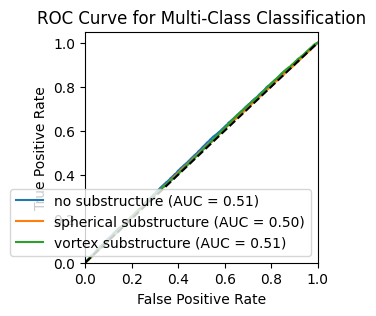

Epoch 2/50
Train Loss: 1.1083, Train Acc: 0.3372
ROC AUC Score: 0.5046


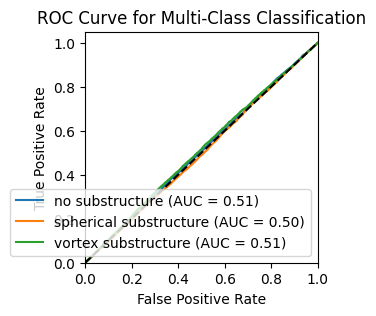

Epoch 3/50
Train Loss: 1.1072, Train Acc: 0.3421
ROC AUC Score: 0.5096


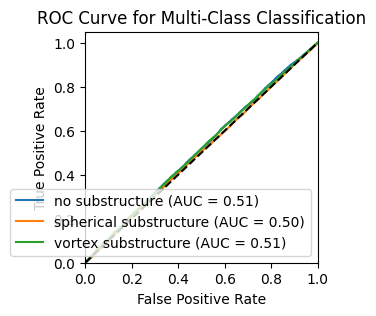

Epoch 4/50
Train Loss: 1.1026, Train Acc: 0.3463
ROC AUC Score: 0.5202


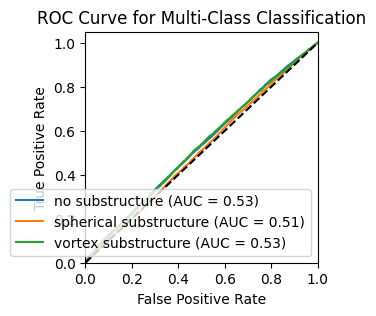

Epoch 5/50
Train Loss: 1.1045, Train Acc: 0.3465
ROC AUC Score: 0.5186


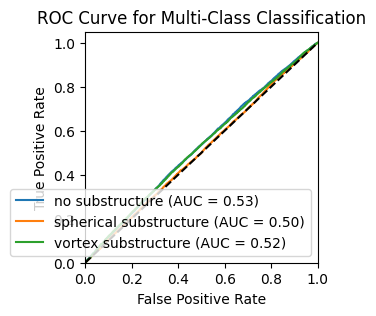

Epoch 6/50
Train Loss: 1.0994, Train Acc: 0.3574
ROC AUC Score: 0.5324


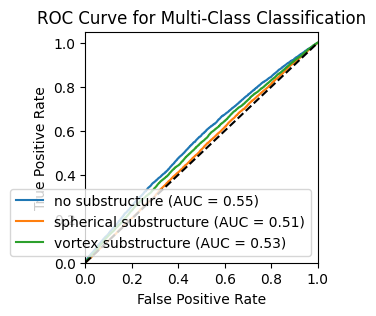

Epoch 7/50
Train Loss: 1.0925, Train Acc: 0.3715
ROC AUC Score: 0.5493


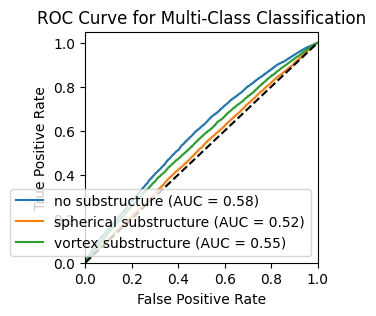

Epoch 8/50
Train Loss: 1.0831, Train Acc: 0.3932
ROC AUC Score: 0.5731


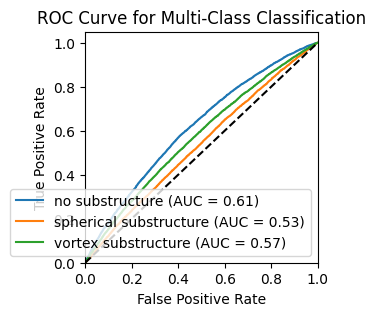

Epoch 9/50
Train Loss: 1.0229, Train Acc: 0.4510
ROC AUC Score: 0.6484


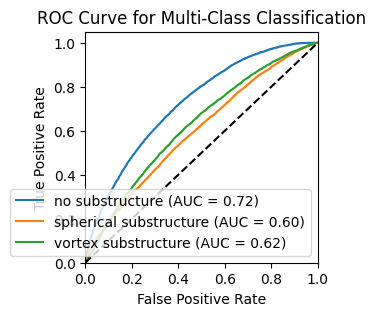

Epoch 10/50
Train Loss: 0.8641, Train Acc: 0.5767
ROC AUC Score: 0.7522


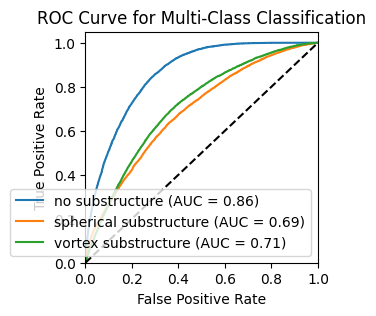

Epoch 11/50
Train Loss: 0.7295, Train Acc: 0.6662
ROC AUC Score: 0.8097


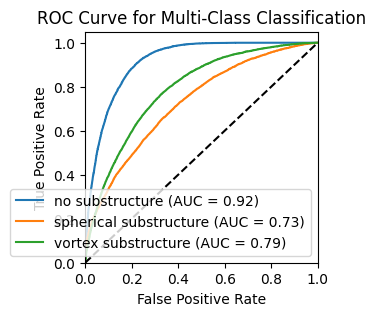

Epoch 12/50
Train Loss: 0.6110, Train Acc: 0.7328
ROC AUC Score: 0.8540


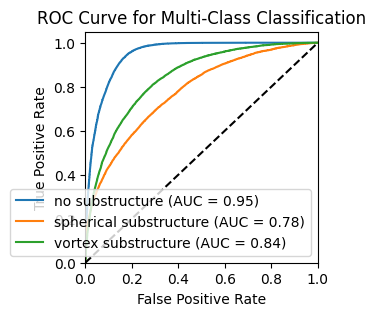

Epoch 13/50
Train Loss: 0.5210, Train Acc: 0.7822
ROC AUC Score: 0.8890


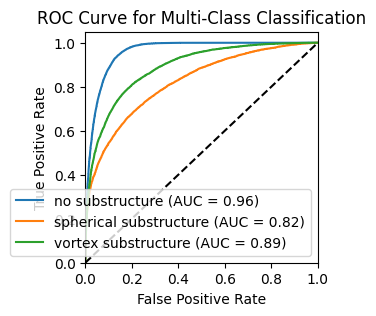

Epoch 14/50
Train Loss: 0.4548, Train Acc: 0.8144
ROC AUC Score: 0.9124


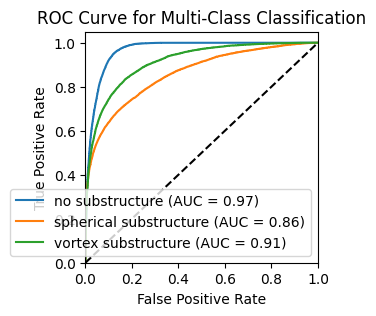

Epoch 15/50
Train Loss: 0.4094, Train Acc: 0.8375
ROC AUC Score: 0.9285


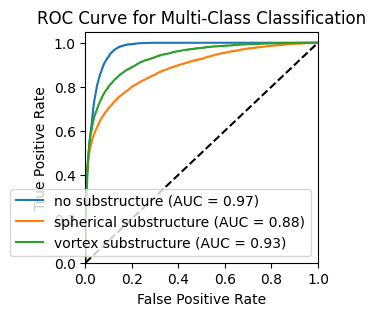

Epoch 16/50
Train Loss: 0.3704, Train Acc: 0.8542
ROC AUC Score: 0.9417


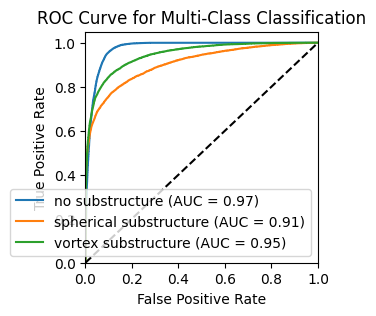

Epoch 17/50
Train Loss: 0.3383, Train Acc: 0.8667
ROC AUC Score: 0.9494


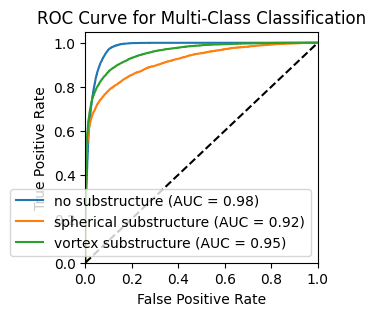

Epoch 18/50
Train Loss: 0.3237, Train Acc: 0.8755
ROC AUC Score: 0.9540


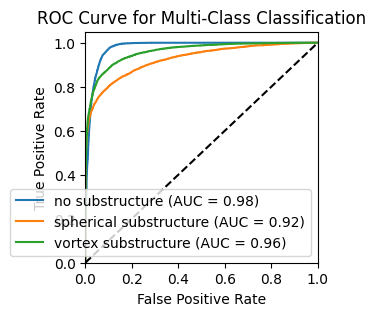

Epoch 19/50
Train Loss: 0.3016, Train Acc: 0.8847
ROC AUC Score: 0.9594


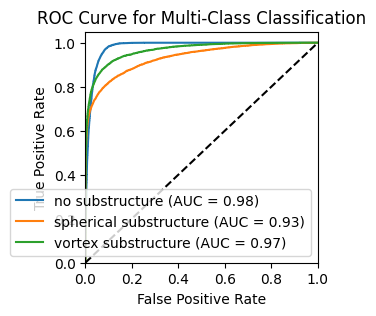

Epoch 20/50
Train Loss: 0.2906, Train Acc: 0.8888
ROC AUC Score: 0.9642


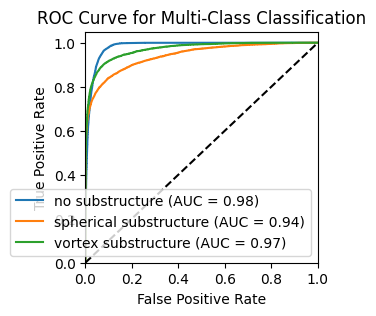

Epoch 21/50
Train Loss: 0.2747, Train Acc: 0.8966
ROC AUC Score: 0.9662


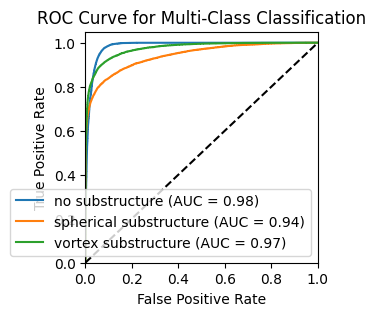

Epoch 22/50
Train Loss: 0.2666, Train Acc: 0.8991
ROC AUC Score: 0.9678


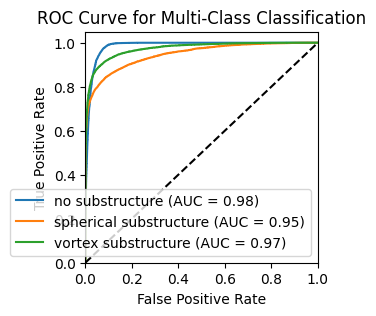

Epoch 23/50
Train Loss: 0.2564, Train Acc: 0.9029
ROC AUC Score: 0.9704


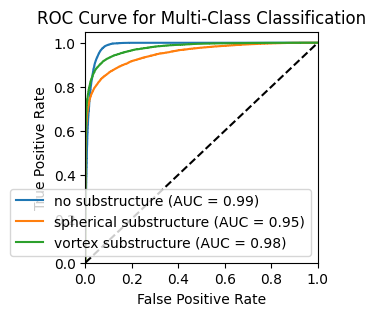

Epoch 24/50
Train Loss: 0.2514, Train Acc: 0.9052
ROC AUC Score: 0.9711


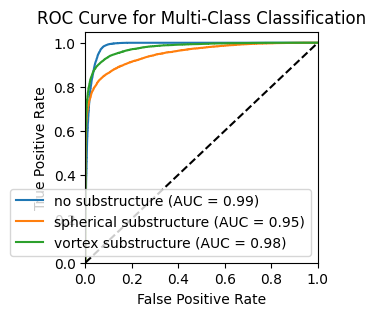

Epoch 25/50
Train Loss: 0.2419, Train Acc: 0.9104
ROC AUC Score: 0.9732


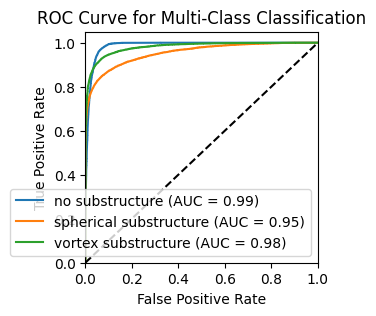

Epoch 26/50
Train Loss: 0.2382, Train Acc: 0.9107
ROC AUC Score: 0.9738


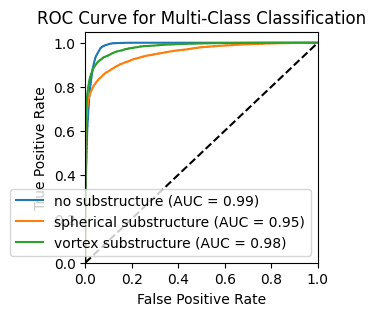

Epoch 27/50
Train Loss: 0.2320, Train Acc: 0.9137
ROC AUC Score: 0.9748


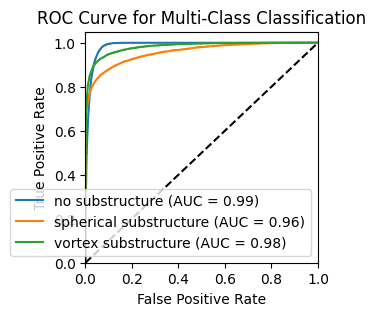

Epoch 28/50
Train Loss: 0.2236, Train Acc: 0.9167
ROC AUC Score: 0.9757


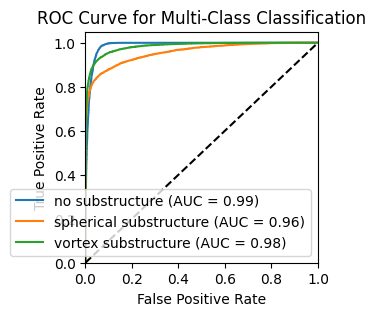

Epoch 29/50
Train Loss: 0.2222, Train Acc: 0.9177
ROC AUC Score: 0.9758


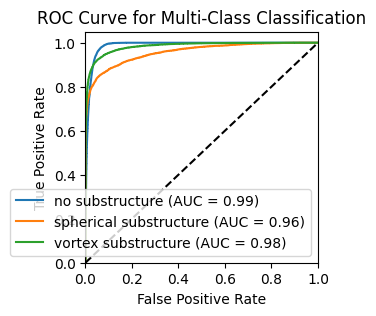

Epoch 30/50
Train Loss: 0.2124, Train Acc: 0.9202
ROC AUC Score: 0.9778


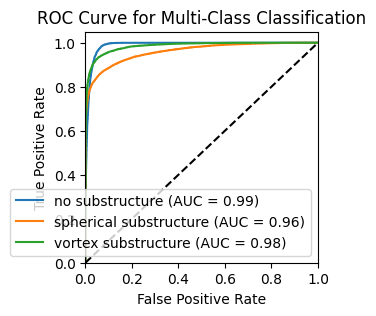

Epoch 31/50
Train Loss: 0.2115, Train Acc: 0.9233
ROC AUC Score: 0.9782


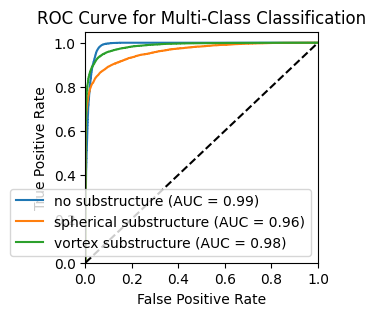

Epoch 32/50
Train Loss: 0.2082, Train Acc: 0.9227
ROC AUC Score: 0.9787


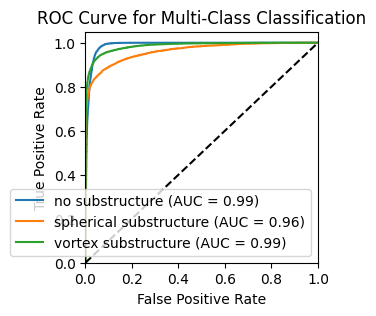

Epoch 33/50
Train Loss: 0.2028, Train Acc: 0.9257
ROC AUC Score: 0.9796


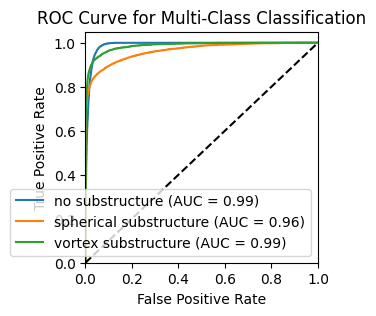

Epoch 34/50
Train Loss: 0.1983, Train Acc: 0.9260
ROC AUC Score: 0.9809


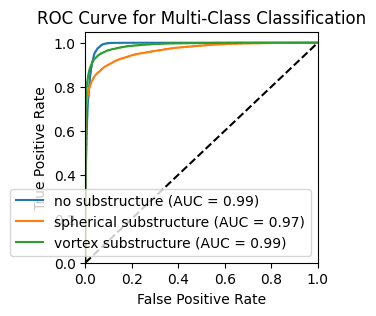

Epoch 35/50
Train Loss: 0.1965, Train Acc: 0.9287
ROC AUC Score: 0.9814


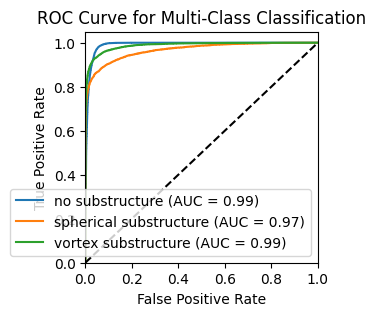

Epoch 36/50
Train Loss: 0.1882, Train Acc: 0.9307
ROC AUC Score: 0.9830


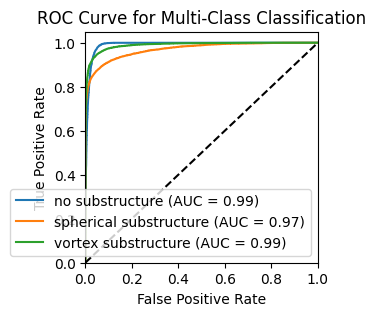

Epoch 37/50
Train Loss: 0.1867, Train Acc: 0.9314
ROC AUC Score: 0.9834


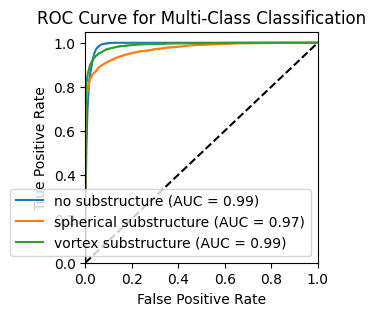

Epoch 38/50
Train Loss: 0.1820, Train Acc: 0.9337
ROC AUC Score: 0.9831


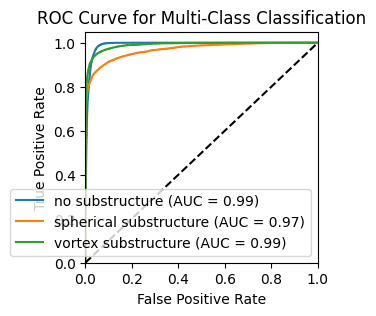

Epoch 39/50
Train Loss: 0.1828, Train Acc: 0.9335
ROC AUC Score: 0.9822


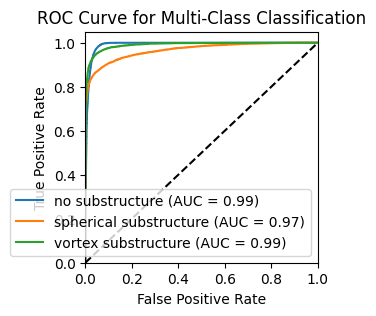

Epoch 40/50
Train Loss: 0.1754, Train Acc: 0.9357
ROC AUC Score: 0.9835


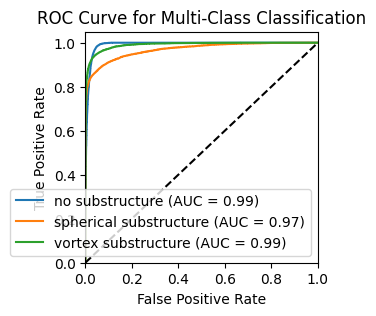

Epoch 41/50
Train Loss: 0.1768, Train Acc: 0.9358
ROC AUC Score: 0.9838


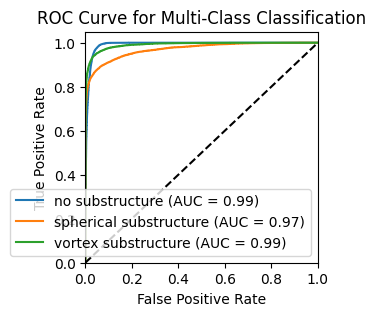

Epoch 42/50
Train Loss: 0.1741, Train Acc: 0.9357
ROC AUC Score: 0.9843


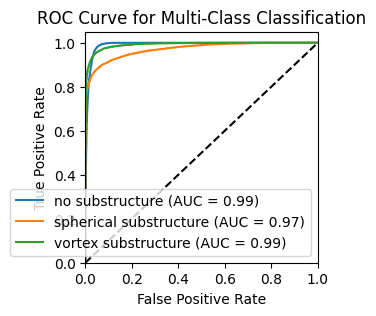

Epoch 43/50
Train Loss: 0.1709, Train Acc: 0.9380
ROC AUC Score: 0.9860


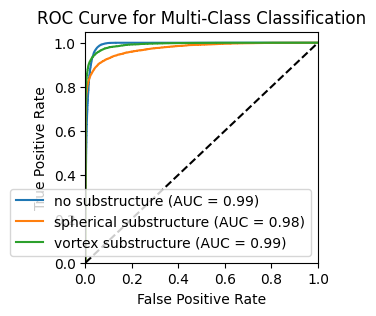

Epoch 44/50
Train Loss: 0.1651, Train Acc: 0.9401
ROC AUC Score: 0.9866


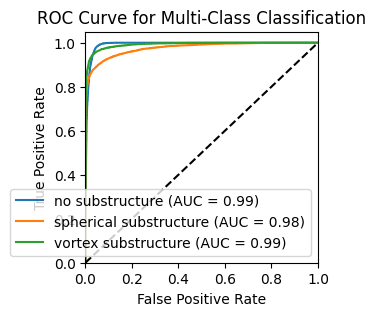

Epoch 45/50
Train Loss: 0.1675, Train Acc: 0.9381
ROC AUC Score: 0.9863


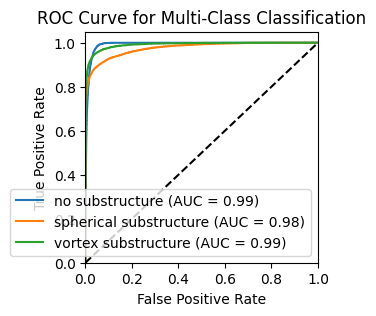

Epoch 46/50
Train Loss: 0.1645, Train Acc: 0.9403
ROC AUC Score: 0.9864


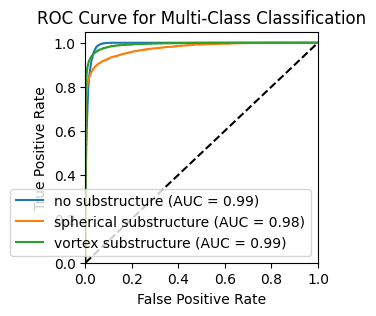

Epoch 47/50
Train Loss: 0.1576, Train Acc: 0.9427
ROC AUC Score: 0.9876


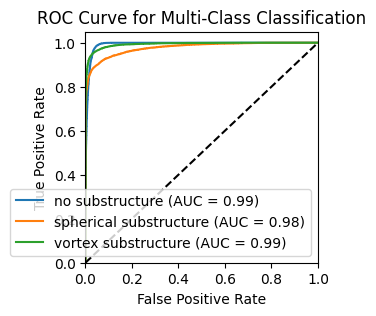

Epoch 48/50
Train Loss: 0.1583, Train Acc: 0.9431
ROC AUC Score: 0.9879


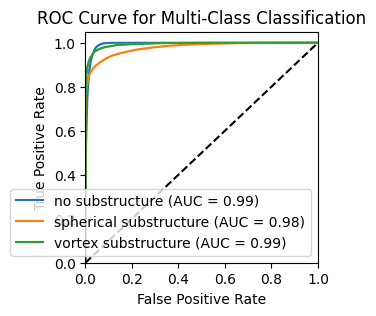

Epoch 49/50
Train Loss: 0.1563, Train Acc: 0.9432
ROC AUC Score: 0.9877


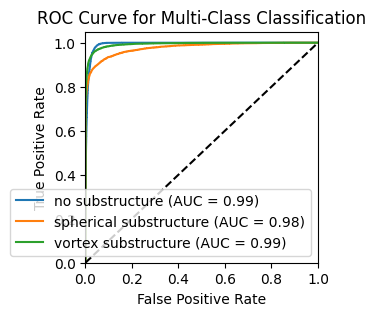

Epoch 50/50
Train Loss: 0.1531, Train Acc: 0.9451
ROC AUC Score: 0.9884


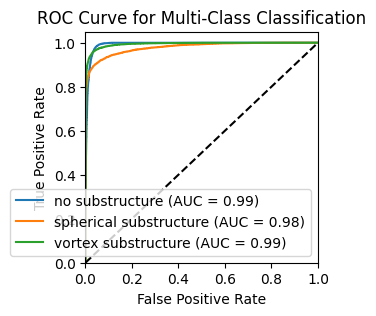

In [8]:

# Training parameters
num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model.parameters(), lr=0.0003)

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    model.train()  # Set model to training mode

    train_loss = 0.0
    correct_predictions = 0
    total_samples = 0  # Keep track of total samples

    y_true = []
    y_scores = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct_predictions += (preds == labels).sum()
        total_samples += labels.size(0)  # Accumulate total number of samples

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        y_true.extend(labels.cpu().numpy())  # Convert labels to NumPy
        y_scores.extend(outputs.detach().cpu().numpy())  # Convert outputs to NumPy

    # Compute average loss and accuracy
    train_loss /= len(train_loader)
    train_acc = correct_predictions / total_samples  # Correct accuracy computation

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Convert lists to NumPy arrays for ROC-AUC calculation
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # ROC-AUC computation
    n_classes = len(train_data.class_to_idx)  #  len(class_dict) # or len(np.unique(y_true))]
    fpr, tpr, roc_auc = {}, {}, []

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
        roc_auc.append(roc_auc_score((y_true == i).astype(int), y_scores[:, i]))

    # Average AUC score
    roc_score = np.mean(roc_auc)
    print(f"ROC AUC Score: {roc_score:.4f}")

    # Plot ROC curve
    plt.figure(figsize=(3,3))
    class_dict = {0: "no substructure", 1: "spherical substructure", 2: "vortex substructure"}

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_dict[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.show()

# Save trained model
torch.save(model.state_dict(), "resnet_model.pth")


# Evaluating the Model

Val Loss: 0.3417, Val Acc: 0.9073
ROC AUC Score: 0.9779


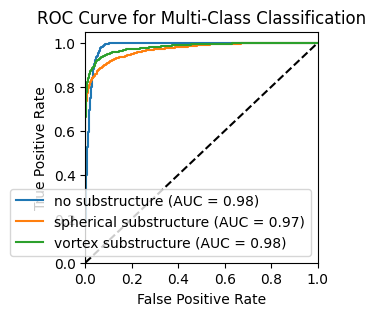

In [9]:
model.eval()  # Set model to evaluation mode

val_loss = 0.0
correct_predictions = 0
total_samples = 0

y_true = []
y_scores = []

with torch.no_grad():  # Disable gradient computation
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        loss = criterion(outputs, labels)
        val_loss += loss.item() * labels.size(0)  # Accumulate loss

        y_true.extend(labels.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())

# Compute average loss and accuracy
val_loss /= total_samples
val_acc = correct_predictions / total_samples

print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Convert lists to NumPy arrays for ROC-AUC calculation
y_true = np.array(y_true)
y_scores = np.array(y_scores)

    # ROC-AUC computation
n_classes = len(val_data.class_to_idx)  #  len(class_dict) # or len(np.unique(y_true))]
fpr, tpr, roc_auc = {}, {}, []

for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
        roc_auc.append(roc_auc_score((y_true == i).astype(int), y_scores[:, i]))

    # Average AUC score
roc_score = np.mean(roc_auc)
print(f"ROC AUC Score: {roc_score:.4f}")

    # Plot ROC curve
plt.figure(figsize=(3,3))
class_dict = {0: "no substructure", 1: "spherical substructure", 2: "vortex substructure"}

for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_dict[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()